In [1]:
import xarray
import fsspec
import numpy as np
#import s3fs
import proplot
import os

from matplotlib import pyplot as plt
import pandas

/tube1/cha674/Anaconda_Install/miniconda/envs/py3/lib/python3.7/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]


In [2]:
AIMS_data_path ='/oa-decadal-climate/work/observations/CARSv2_ancillary/data_originator/AIMS_database_CTD'
dir_contents = os.listdir(AIMS_data_path)

AIMS_CTD_file_list = []
for i_file in dir_contents:
    if os.path.isfile(os.path.join(AIMS_data_path,i_file)) and i_file.endswith('.csv'):
        AIMS_CTD_file_list.append(os.path.join(AIMS_data_path,i_file))

In [7]:
def Get_CODA_id(dates,source_data,obs_platform,year):
    
    CODA_id_length = 20
    CODA_ID = np.array(['' for _ in range(dates.size)], dtype='S{}'.format(CODA_id_length))
    
    unique_dates = np.unique(CODA_dates)

    
    for i_date in unique_dates:
    
        if not pandas.isnull(i_date):
            
            idx_for_date   =  np.nonzero(dates == i_date)[0]
            count_for_date =  idx_for_date.size
            i_profile = 1
            
            for i_index in idx_for_date:
                #print(i_index)
                CODA_id_current_profiles = source_data + obs_platform + i_date.strftime('%Y%m%d') + f'{i_profile:04}'
                CODA_ID[i_index] = CODA_id_current_profiles
                i_profile = i_profile+1
                
            #END for i_index
        #if not isnull
    #END for i_date

    bad_dates_idx = np.nonzero(pandas.isnull(dates))[0]
 
    bad_profile_counter = 1
    
    for i_bad_idx in bad_dates_idx:
        CODA_id_current_profiles = source_data + obs_platform + str(year) + 'XXXX' + f'{bad_profile_counter:04}'
        CODA_ID[i_bad_idx] = CODA_id_current_profiles
        bad_profile_counter = bad_profile_counter+1

    return CODA_ID

In [3]:
def get_var_from_aims(AIMS_CTD_file_list,variable_column_names,depth_column_names,value_column_names):
    
    bad_profile = 0
    max_row_size = 0 
    file_counter =  0
    
    data_profiles   = []
    depth_profiles  = []
    
    QAQC_values_profile   = []
    QAQC_flag_profile     = []
    
    
    QAQC_value_column_names = ['QAQC_VALUE','Unnamed: 3']
    QAQC_flag_column_names = ['QAQC_FLAG','Unnamed: 4']
    parameter_column_names     = ['PARAMETER','%Trans']
    
    file_counter = 0
    
    var_name_to_use = []
    for i_file in AIMS_CTD_file_list:
        
        AIMS_dataframe = pandas.read_csv(i_file,header=16,skip_blank_lines=False)
        
        col_names_temp_dataframe = AIMS_dataframe.columns
        
        for i_depth_name in depth_column_names:
            if i_depth_name in col_names_temp_dataframe:
                depth_name_to_use = i_depth_name
        
        for i_param_name in parameter_column_names:
            if i_param_name in col_names_temp_dataframe:
                param_name_to_use = i_param_name
        
        for i_value_name in value_column_names:
            if i_value_name in col_names_temp_dataframe:
                value_name_to_use = i_value_name

        for i_qc_val_name in QAQC_value_column_names:
            if i_qc_val_name in col_names_temp_dataframe:
                QC_val_name_to_use = i_qc_val_name

        for i_qc_flag_name in QAQC_flag_column_names:
            if i_qc_flag_name in col_names_temp_dataframe:
                QC_flag_name_to_use = i_qc_flag_name

        for i_var_name in variable_column_names:
            if i_var_name in AIMS_dataframe[param_name_to_use].unique():
                var_name_to_use.append(i_var)

        
        #print(AIMS_dataframe[param_name_to_use].isin(variable_column_names))
        
        

        depth = AIMS_dataframe.loc[AIMS_dataframe[param_name_to_use].isin(variable_column_names)][depth_name_to_use].values
        data  = AIMS_dataframe.loc[AIMS_dataframe[param_name_to_use].isin(variable_column_names)][value_name_to_use].values

        QAQC_val = AIMS_dataframe.loc[AIMS_dataframe[param_name_to_use].isin(variable_column_names)][QC_val_name_to_use].values
        QAQC_flag  = AIMS_dataframe.loc[AIMS_dataframe[param_name_to_use].isin(variable_column_names)][QC_flag_name_to_use].values

        unique_depth_values, idx_unique, count = np.unique(depth, return_counts=True, return_index=True)
    
        depth     = depth[idx_unique]
        data      = data[idx_unique]
        QAQC_val  = QAQC_val[idx_unique]
        QAQC_flag = QAQC_flag[idx_unique]
        

        data_profiles.append(data)
        depth_profiles.append(depth)
        QAQC_values_profile.append(QAQC_val)
        QAQC_flag_profile.append(QAQC_flag)

        if max_row_size<depth.size:
            max_row_size = depth.size
    
        file_counter = file_counter+1  
    
    return data_profiles,depth_profiles,QAQC_values_profile,QAQC_flag_profile,var_name_to_use
    

In [4]:
import warnings

warnings.filterwarnings('ignore')

vars_to_get = ['z','Temperature','Oxygen','Salinity']


depth_column_name         = ['DEPTH','1.0','2.0']
value_column_name       = ['VALUE','Unnamed: 2']
file_counter = 0
failed_profile = 0

import csv

AIMS_latitude  = []
AIMS_longitude = []
AIMS_date      = []

for i_file in AIMS_CTD_file_list:
    with open(i_file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        found_date = False
        for row in csv_reader:
            #print(row)
            if row.count('LATITUDE:')>0:
                AIMS_latitude.append(float(row[1]))
            elif row.count('LONGITUDE:')>0:
                AIMS_longitude.append(float(row[1]))
            
            
            elif row.count('SAMPLE DATE:')>0: #row.count('SAMPLE DATE:')>0:
                found_date = True
                AIMS_date.append(pandas.to_datetime(row[1]))
            line_count = line_count + 1
            if line_count > 20 and not found_date:
                #AIMS_longitude.pop()
                AIMS_date.append(np.datetime64('NaT'))
                break

                
    
data_container = {}

for i_var in vars_to_get:
    data_container[i_var] = []
    data_container[i_var+'_QAQC_value'] = []
    data_container[i_var+'_QAQC_flag'] = []

    
attribute_container_for_year = {}

for i_var in vars_to_get:
    attribute_container_for_year[i_var] = []
    attribute_container_for_year[i_var+'_QAQC_value'] = []
    attribute_container_for_year[i_var+'_QAQC_flag'] = []


    

var_column_name         = ['Temp(°C)','Unnamed: 2','tv268C: Temperature [ITS-68  deg C]','tv268C: Temperature [IPTS-68  deg C]','t068C: Temperature [ITS-68  deg C]']
                                              #get_var_from_aims(AIMS_CTD_file_list,variable_column_names,depth_column_names,value_column_names)
temp_profiles, temp_depth_profiles,temp_QAQC_val,temp_QAQC_flag, temp_name_to_use = get_var_from_aims(AIMS_CTD_file_list,var_column_name,depth_column_name,value_column_name)

data_container['Temperature'] = temp_profiles
data_container['Temperature' + '_QAQC_value'] = temp_QAQC_val
data_container['Temperature' + '_QAQC_flag'] = temp_QAQC_flag

attribute_container_for_year['Temperature'] = {'standard_name':'sea_water_temperature','originator name':temp_name_to_use,'units':'degree C'}


var_column_name         = ['Salinity','sal00: Salinity Practical [PSU]']
salt_profiles, salt_depth_profiles,salt_QAQC_val,salt_QAQC_flag,salt_name = get_var_from_aims(AIMS_CTD_file_list,var_column_name,depth_column_name,value_column_name)

data_container['Salinity'] = salt_profiles
data_container['Salinity' + '_QAQC_value'] = salt_QAQC_val
data_container['Salinity' + '_QAQC_flag'] = salt_QAQC_flag

attribute_container_for_year['Salinity'] = {'standard_name':'sea_water_salinity','originator name':salt_name}


var_column_name = ['Oxygen (µmol/kg)','sbeox0PS: Oxygen SBE 43 [% saturation]']
oxygen_profiles, oxygen_depth_profiles,oxygen_QAQC_val,oxygen_QAQC_flag,oxygen_name = get_var_from_aims(AIMS_CTD_file_list,var_column_name,depth_column_name,value_column_name)
data_container['Oxygen'] = oxygen_profiles
data_container['Oxygen' + '_QAQC_value'] = oxygen_QAQC_val
data_container['Oxygen' + '_QAQC_flag'] = oxygen_QAQC_flag
attribute_container_for_year['Oxygen'] = {'standard_name':'volume_fraction_of_oxygen_in_sea_water','originator name':oxygen_name,'units':'umol/kg'}



data_container['z'] = temp_depth_profiles
attribute_container_for_year['z'] = {'standard_name':'depth','originator name':'DEPTH (m)','units':'m'}



AIMS_date       = np.asarray(AIMS_date)
AIMS_longitude  = np.asarray(AIMS_longitude)
AIMS_latitude   = np.asarray(AIMS_latitude)


attribute_container_for_year['lon'] =  {'standard_name':'longitude','units':'degrees_east'}
attribute_container_for_year['lat'] =  {'standard_name':'latitude','units':'degrees_north'}
attribute_container_for_year['time'] = {'standard_name':'time'} #,'units':'degrees_north'}

#standard_name = ""
attribute_container_for_year['z']


{'standard_name': 'depth', 'originator name': 'DEPTH (m)', 'units': 'm'}

In [6]:
CODA_to_AIMS_key = {'Temperature':'TEMP',
                   'Salinity':'PSAL',
                   'Oxygen':'DOXY',
                   'z':'DEPTH'} 

In [29]:
output_path = '/oa-decadal-climate/work/observations/CARSv2_ancillary/CODA/WOD_CODA_test_v2'
FILL_VALUE = -10000000000.0

years_in_AIMS = pandas.to_datetime(AIMS_date).year


unique_years = np.sort(np.unique(years_in_AIMS)).astype('int')


hard_code_output = {'country':'Australia',
                    'dbase_orig':'AIMSWqCtd',
                    'Project':'AIMSWqCtd',
                    'Platform':'Various',
                    'Institute':'Australian Institute of Marine Science',
                    'Temperature_Instrument':'CTD'}

WOD_CODA_reference_file_name = '/oa-decadal-climate/work/observations/CARSv2_ancillary/CODA/WOD_CODA_test_v2/2015/WOD_CODA_2015_ctd_test_all_vars.nc'
WOD_CODA_reference_dataset   = xarray.open_dataset(WOD_CODA_reference_file_name)




for i_year in unique_years[1::]:
    
    print('Working with year: ', i_year)
    idx_for_year = np.nonzero(years_in_AIMS.values==i_year)[0]
    
    time_for_year = AIMS_date[idx_for_year]
    
    idx_time_sort = np.argsort(time_for_year)
    
    files_in_year = [AIMS_CTD_file_list[i] for i in idx_for_year]
    files_in_year_sorted = [files_in_year[i] for i in idx_time_sort]

    
    max_row_size =0
    cast_index = np.arange(1,len(idx_for_year)+1)
    
    profiles_for_year = {}
    for i_var in vars_to_get:
        profiles_for_year[i_var] = []
        for i_cast in range(0,len(idx_for_year)):

            profiles_for_year[i_var].append(data_container[i_var][idx_for_year[i_cast]])
        
            if max_row_size<profiles_for_year[i_var][-1].size:
                max_row_size = profiles_for_year[i_var][-1].size
    
    profiles_for_year_sorted = {}
    for i_var in vars_to_get:
        profiles_for_year_sorted[i_var] = [profiles_for_year[i_var][i] for i in idx_time_sort]
    
    #attrs = attribute_container_for_year['lat']
    latitude_for_year = AIMS_latitude[idx_for_year][idx_time_sort]
    longitude_for_year= AIMS_longitude[idx_for_year][idx_time_sort]
    time_for_year     =    AIMS_date[idx_for_year][idx_time_sort]

    

    CODA_output_dataset   = xarray.DataArray(AIMS_latitude[idx_for_year][idx_time_sort],dims=['cast'],coords={'cast':cast_index},
                                            attrs = attribute_container_for_year['lat'])
    CODA_output_dataset   = CODA_output_dataset.to_dataset(name='lat')
    CODA_output_dataset['lat'] = CODA_output_dataset['lat'].fillna(int(FILL_VALUE))

    CODA_output_dataset['lon']  = xarray.DataArray(AIMS_longitude[idx_for_year][idx_time_sort],dims=['cast'],coords={'cast':cast_index},
                                                   attrs = attribute_container_for_year['lon'])
    CODA_output_dataset['lon'] = CODA_output_dataset['lon'].fillna(int(FILL_VALUE))

    CODA_output_dataset['time']       = xarray.DataArray(pandas.to_datetime(AIMS_date)[idx_for_year][idx_time_sort],dims=['cast'],coords={'cast':cast_index},
                                                         attrs = attribute_container_for_year['time'])
    CODA_output_dataset['time'].encoding['units'] = 'days since 1770-01-01T00:00:00+00:00'
    CODA_output_dataset['time'].encoding['calendar'] = 'proleptic_gregorian'
    CODA_output_dataset['time'].encoding['_FillValue'] = FILL_VALUE    
    
    for i_var in vars_to_get:
        output_array = np.nan*np.zeros([len(idx_for_year),max_row_size])
         
        
        for i_cast in range(0,len(idx_for_year)):
            current_profile = profiles_for_year_sorted[i_var][i_cast]
            output_array[i_cast,0:len(current_profile)] = current_profile
    
        CODA_output_dataset[i_var]  = xarray.DataArray(output_array,dims=['cast','z_index'],
                                      coords= {'cast':cast_index,'z_index':np.arange(0,max_row_size,1)},
                                      attrs = attribute_container_for_year[i_var])
        CODA_output_dataset[i_var]  = CODA_output_dataset[i_var].fillna(int(FILL_VALUE))


    
    for i_ancillary_var in hard_code_output.keys():
        ancillary_data    = np.zeros([cast_index.size],dtype='S{}'.format(20))
        ancillary_data[:] = hard_code_output[i_ancillary_var]
        
        CODA_output_dataset[i_ancillary_var]  = xarray.DataArray(ancillary_data,dims=['cast'],
                                                                 coords= {'cast':cast_index})
    
        CODA_output_dataset[i_ancillary_var] = CODA_output_dataset[i_ancillary_var].fillna(int(FILL_VALUE))

        
    for i_hard_code_ancillary_var in hard_code_output.keys():
        hard_code_ancillary_data_array = np.zeros([len(cast_index)],dtype='S{}'.format(100))
        for i_cast in range(0,len(cast_index)):
            hard_code_ancillary_data_array[i_cast] = hard_code_output[i_hard_code_ancillary_var]
        #END i_cast
        hard_code_attributes = WOD_CODA_reference_dataset[i_hard_code_ancillary_var].attrs
        CODA_output_dataset[i_hard_code_ancillary_var]  = xarray.DataArray(hard_code_ancillary_data_array,dims=['cast'],coords={'cast':cast_index},
                                                                   attrs = hard_code_attributes)

        
    source_data = 'aim'
    i_obs_type  = 'ctd'
    CODA_dates  = CODA_output_dataset['time'].dt.date.values
    CODA_ID     = Get_CODA_id(CODA_dates,source_data,obs_type,i_year)
        
        
    CODA_output_dataset['CODA_id'] = xarray.DataArray(CODA_ID,dims=['cast'],coords={'cast':cast_index},
                                                          attrs={'Comment':'Unique CODA identifier with format <Source Dataset><Obs Platform><YYYYMMDD><Counter for date>'})

    #CODA_output_dataset.attrs = {'Parent files':files_used_for_year}

    
    parent_files = ' '.join(files_in_year_sorted)
    #idx_time_sort = np.argsort(time_for_year)
    CODA_output_dataset.attrs = {'Parent files':parent_files}
    
    output_file_name = 'AIMS_CODA_' + str(i_year) + '_' + str(i_obs_type) + '_test_all_vars.nc'
    print('Writing file:', output_file_name)
    
    encoding = {
            'Temperature': {'_FillValue': FILL_VALUE},
            'Salinity':    {'_FillValue':  FILL_VALUE},
            'Oxygen':      {'_FillValue':  FILL_VALUE},
            'z':           {'_FillValue':  FILL_VALUE}
            }
    
    
    if not os.path.isdir(os.path.join(output_path,str(i_year))):
        os.mkdir(os.path.join(output_path,str(i_year)))
    CODA_output_dataset.to_netcdf(os.path.join(output_path,str(i_year),output_file_name),encoding=encoding) #,engine='netcdf4')

    
    

#np.nanmax(AIMS_temperature_ds['time'])


Working with year:  2000
Writing file: AIMS_CODA_2000_ctd_test_all_vars.nc
Working with year:  2001
Writing file: AIMS_CODA_2001_ctd_test_all_vars.nc
Working with year:  2002
Writing file: AIMS_CODA_2002_ctd_test_all_vars.nc
Working with year:  2003
Writing file: AIMS_CODA_2003_ctd_test_all_vars.nc
Working with year:  2004
Writing file: AIMS_CODA_2004_ctd_test_all_vars.nc
Working with year:  2005
Writing file: AIMS_CODA_2005_ctd_test_all_vars.nc
Working with year:  2006
Writing file: AIMS_CODA_2006_ctd_test_all_vars.nc
Working with year:  2007
Writing file: AIMS_CODA_2007_ctd_test_all_vars.nc
Working with year:  2008
Writing file: AIMS_CODA_2008_ctd_test_all_vars.nc
Working with year:  2009
Writing file: AIMS_CODA_2009_ctd_test_all_vars.nc
Working with year:  2010
Writing file: AIMS_CODA_2010_ctd_test_all_vars.nc
Working with year:  2011
Writing file: AIMS_CODA_2011_ctd_test_all_vars.nc
Working with year:  2012
Writing file: AIMS_CODA_2012_ctd_test_all_vars.nc
Working with year:  2013


In [28]:
CODA_output_dataset

<xarray.Dataset>
Dimensions:                 (cast: 30, z_index: 40)
Coordinates:
  * cast                    (cast) int64 1 2 3 4 5 6 7 ... 24 25 26 27 28 29 30
  * z_index                 (z_index) int64 0 1 2 3 4 5 6 ... 34 35 36 37 38 39
Data variables: (12/14)
    lat                     (cast) float64 -13.86 -13.86 ... -17.76 -17.73
    lon                     (cast) float64 143.7 143.7 143.6 ... 146.2 146.2
    time                    (cast) datetime64[ns] 2000-02-08 ... 2000-12-08
    z                       (cast, z_index) float64 1.0 2.0 ... -1e+10 -1e+10
    Temperature             (cast, z_index) float64 23.2 23.19 ... -1e+10 -1e+10
    Oxygen                  (cast, z_index) float64 -1e+10 -1e+10 ... -1e+10
    ...                      ...
    dbase_orig              (cast) |S100 b'AIMSWqCtd' ... b'AIMSWqCtd'
    Project                 (cast) |S100 b'AIMSWqCtd' ... b'AIMSWqCtd'
    Platform                (cast) |S100 b'Various' b'Various' ... b'Various'
    Institute               (cast) |S100 b'Australian Institute of Marine Sci...
    Temperature_Instrument  (cast) |S100 b'CTD' b'CTD' b'CTD' ... b'CTD' b'CTD'
    CODA_id                 (cast) |S20 b'aimctd200002080001' ... b'aimctd200...
Attributes:
    Parent files:  /oa-decadal-climate/work/observations/CARSv2_ancillary/dat...

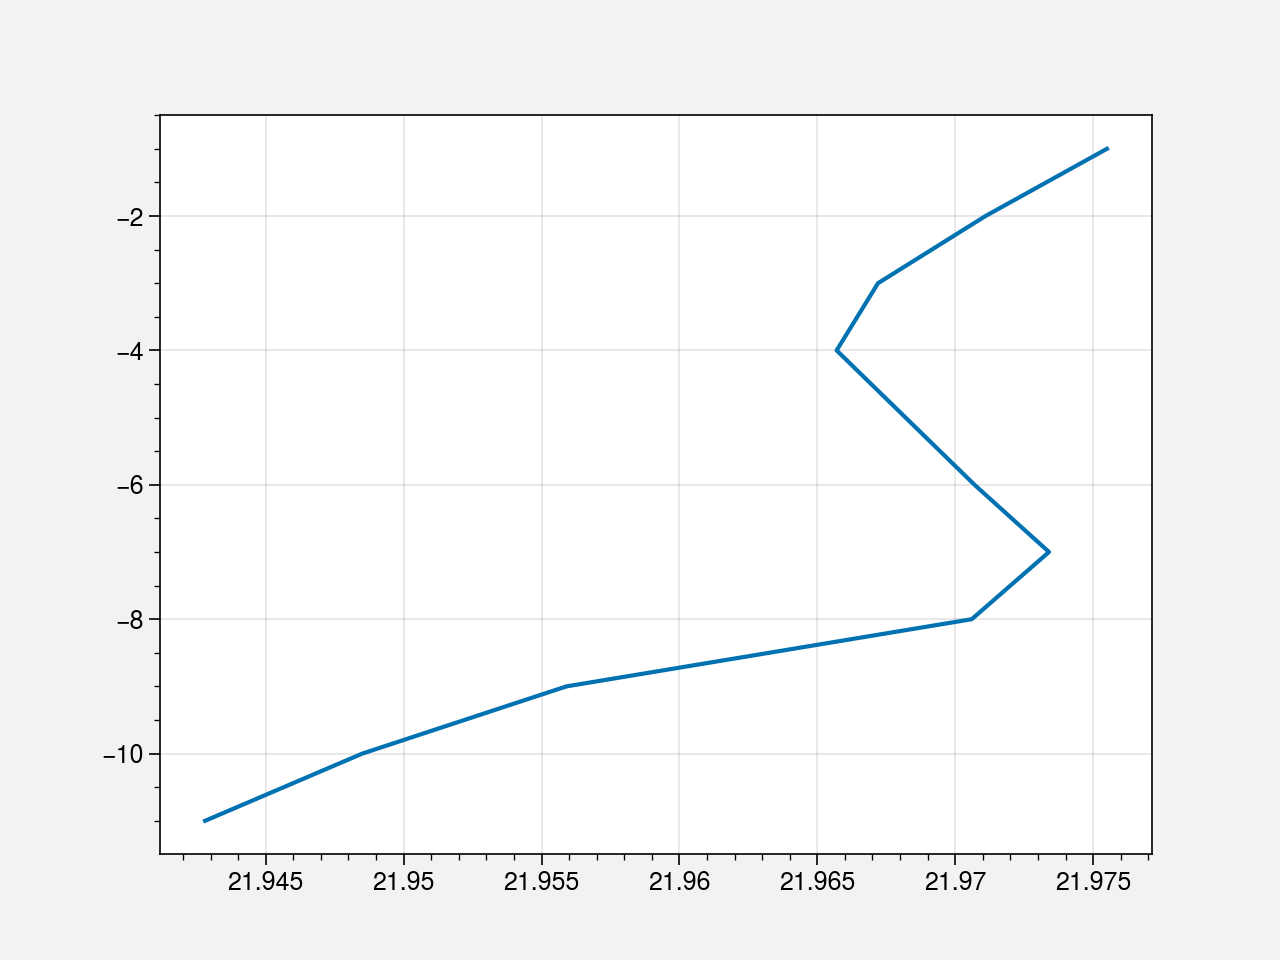

In [26]:
i_cast = 20

T = CODA_output_dataset['Temperature'][i_cast]
z = CODA_output_dataset['z'][i_cast]

nan_mask = T==FILL_VALUE
T[nan_mask] = np.nan
z[nan_mask] = np.nan
plt.plot(T,-z)

In [10]:
files_used_for_year

NameError: name 'files_used_for_year' is not defined

In [17]:
vars_to_get

['z', 'Temperature', 'Oxygen', 'Salinity']

In [16]:
CODA_output_dataset

<xarray.Dataset>
Dimensions:                 (cast: 30, z_index: 40)
Coordinates:
  * cast                    (cast) int64 1 2 3 4 5 6 7 ... 24 25 26 27 28 29 30
  * z_index                 (z_index) int64 0 1 2 3 4 5 6 ... 34 35 36 37 38 39
Data variables: (12/14)
    lat                     (cast) float64 -13.86 -13.86 ... -17.76 -17.73
    lon                     (cast) float64 143.7 143.7 143.6 ... 146.2 146.2
    time                    (cast) datetime64[ns] 2000-02-08 ... 2000-12-08
    z                       (cast, z_index) float64 1.0 2.0 3.0 ... nan nan nan
    Temperature             (cast, z_index) float64 23.2 23.19 23.19 ... nan nan
    Oxygen                  (cast, z_index) float64 nan nan nan ... nan nan nan
    ...                      ...
    dbase_orig              (cast) |S20 b'AIMSWqCtd' ... b'AIMSWqCtd'
    Project                 (cast) |S20 b'AIMSWqCtd' ... b'AIMSWqCtd'
    Platform                (cast) |S20 b'Various' b'Various' ... b'Various'
    Institute               (cast) |S20 b'Australian Institute' ... b'Austral...
    Temperature_Instrument  (cast) |S20 b'CTD' b'CTD' b'CTD' ... b'CTD' b'CTD'
    CODA_ID                 (cast) |S18 b'aimctd200002080001' ... b'aimctd200...
Attributes:
    Parent files:  /oa-decadal-climate/work/observations/CARSv2_ancillary/dat...

In [100]:
CODA_output_dataset

<xarray.Dataset>
Dimensions:      (cast: 30, z_index: 40)
Coordinates:
  * cast         (cast) int64 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30
  * z_index      (z_index) int64 0 1 2 3 4 5 6 7 8 ... 32 33 34 35 36 37 38 39
Data variables:
    latitude     (cast) float64 -13.86 -13.86 -13.45 ... -17.76 -17.76 -17.73
    longitude    (cast) float64 143.7 143.7 143.6 143.8 ... 146.2 146.2 146.2
    time         (cast) datetime64[ns] 2000-02-08 2000-02-08 ... 2000-12-08
    z            (cast, z_index) float64 1.0 2.0 3.0 4.0 6.0 ... nan nan nan nan
    Temperature  (cast, z_index) float64 23.2 23.19 23.19 23.19 ... nan nan nan
    Oxygen       (cast, z_index) float64 nan nan nan nan nan ... nan nan nan nan
    Salinity     (cast, z_index) float64 35.05 35.05 35.04 35.04 ... nan nan nan
    CODA_ID      (cast) |S18 b'aimctd200002080001' ... b'aimctd200012080004'
Attributes:
    Parent files:  /oa-decadal-climate/work/observations/CARSv2_ancillary/dat...

In [66]:
AIMS_date

array([Timestamp('2011-02-26 00:00:00'), Timestamp('2011-02-26 00:00:00'),
       Timestamp('2011-02-27 00:00:00'), ...,
       Timestamp('2014-09-12 00:00:00'), Timestamp('2015-01-19 00:00:00'),
       Timestamp('2014-02-24 00:00:00')], dtype=object)

ValueError: x and y must have same first dimension, but have shapes (17,) and (0,)

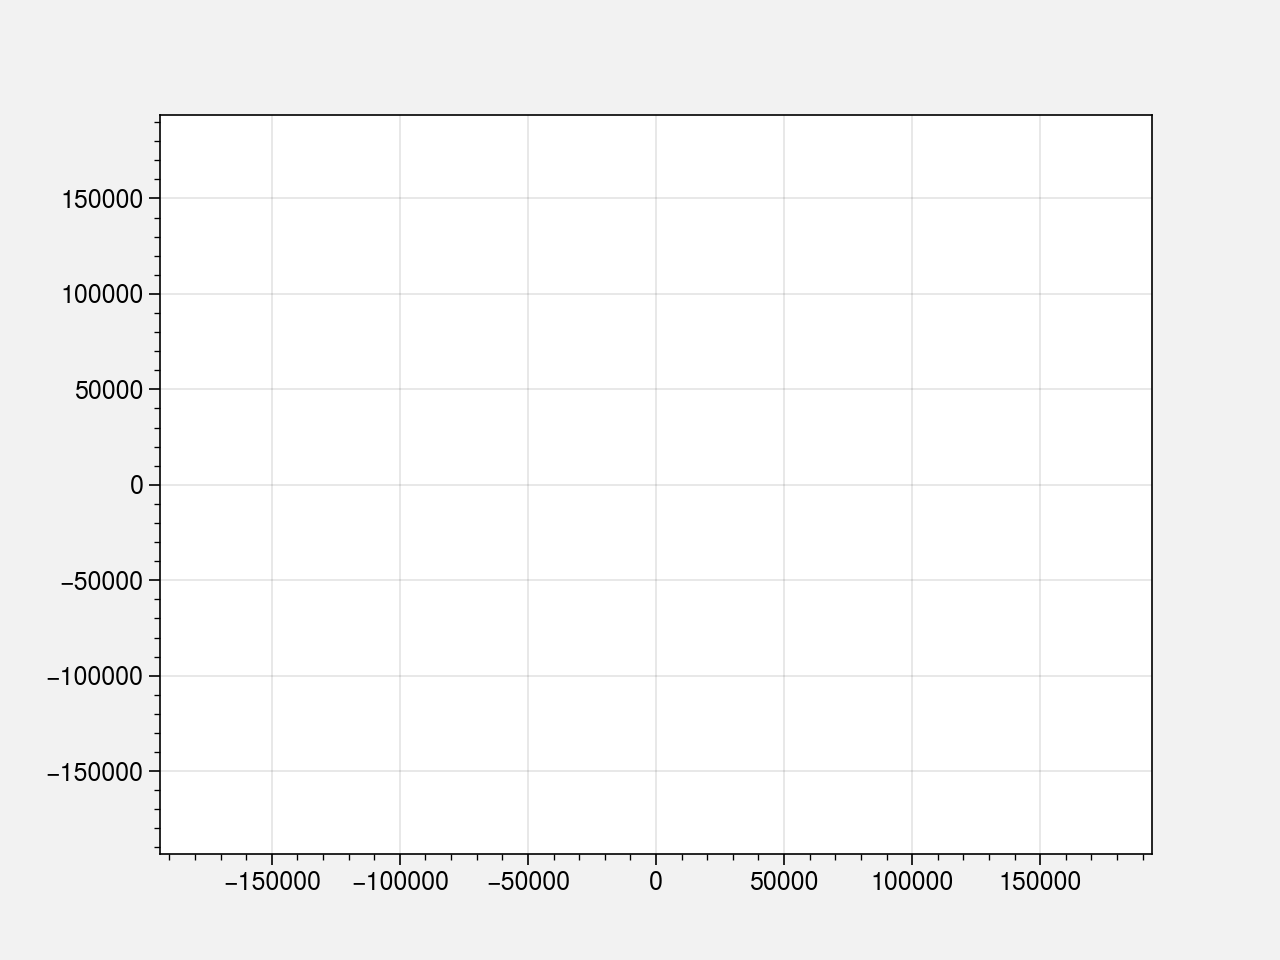

In [43]:
for i_cast in range(0,len(oxygen_profiles)):

    plt.plot(temp_QAQC_val[i_cast],-depth_profiles[i_cast])


In [18]:
oxygen_profiles[i_cast]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na